# Spec2Vec
1. Import MS-MS data from MGF file
2. Create smaller subset of data
3. Train Spec2Vec models for both datasets

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

import helper_functions as functions
import MS_functions

In [3]:
# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

# Import and filter MS-MS data from MGF file (positive ionization mode)

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
**1. Discard spectra with too few peaks.**  
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

**2. Further filtering is ignored here. This is only to do selection for subset.**  

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [4]:
# Import & filter data from all-GNPS dataset
file_json = os.path.join(PATH_MS_DATA, "allGNPS_positive_minpeak10_unfiltered_191107.json")
file_mgf = os.path.join(PATH_MS_DATA, "cleaned_MGFs", "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra.mgf")

spectra, spectra_dict, _, _, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 5.0,
                                                           min_intensity_perc = 0,
                                                           exp_intensity_filter = None, 
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 0,
                                                           min_peaks = 10,
                                                           max_peaks = None,
                                                           peak_loss_words = ['peak_', 'loss_'],
                                                           ignore_losses = True)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\GNPS_all\allGNPS_positive_minpeak10_unfiltered_191107.json
Data will be imported from  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Data\GNPS_all\allGNPS_positive_191106.mgf
----------------------------------------
Take 90290 spectra out of 107290
  Created documents for  90290  of  90290  spectra.0  of  90290  spectra. 90290  spectra.

In [5]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 90290


In [6]:
spectra[10].inchi

'"InChI=1S/C26H43NO6/c1-14(4-7-22(31)27-13-23(32)33)17-5-6-18-24-19(12-21(30)26(17,18)3)25(2)9-8-16(28)10-15(25)11-20(24)29/h14-21,24,28-30H,4-13H2,1-3H3,(H,27,31)(H,32,33)/t14?,15-,16+,17+,18-,19-,20+,21-,24-,25?,26?/m0/s1"'

In [7]:
spectra[10].metadata['spectrumid']

'CCMSLIB00005435513'

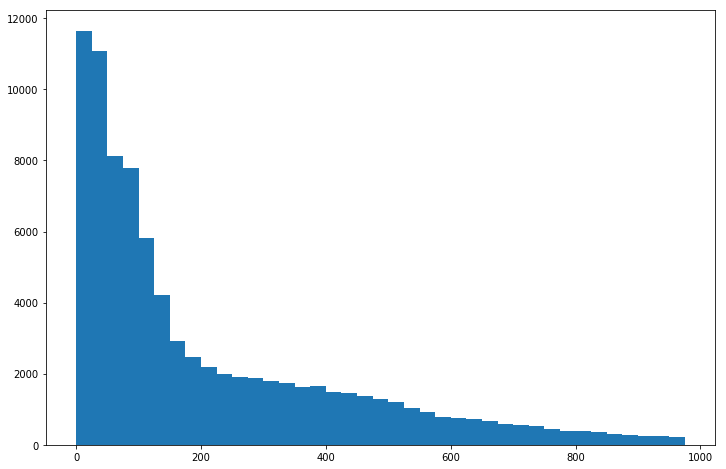

In [30]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,1000,25))

In [27]:
np.array(num_peaks).mean()

390.28969985601947

In [16]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)

(0, 1500)

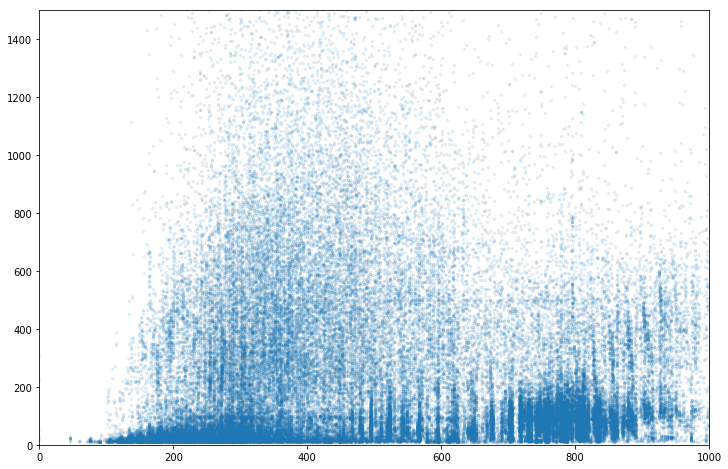

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(pepmasses, num_peaks, alpha= 0.1, s=5)
plt.xlim(0,1000)
plt.ylim(0,1500)

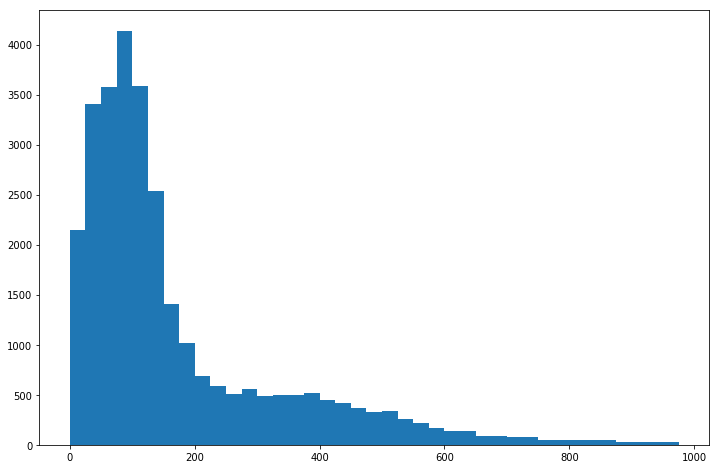

In [32]:
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1000,25))

### Check the amount of annotations we have in the dataset

In [33]:
inchi_lst = []
inchikey_lst = []
smiles_lst = []
spectrumid_lst = []

for spec in spectra:
    if 'inchi' in spec.metadata:
        inchi_lst.append(spec.metadata['inchi'])
    else:
        inchi_lst.append('0')
    if 'inchikey' in spec.metadata:
        inchikey_lst.append(spec.metadata['inchikey'])
    else:
        inchikey_lst.append('0')
    if 'smiles' in spec.metadata:
        smiles_lst.append(spec.metadata['smiles'])
    else:
        smiles_lst.append('0')
    if 'spectrumid' in spec.metadata:
        spectrumid_lst.append(spec.metadata['spectrumid'])
    else:
        spectrumid_lst.append('0')

In [34]:
empty_entry_types = empty_entry_types = ['N/A', 'n/a', 'NA', 0, '0', '""', '', 
                     'nodata', '"InChI=n/a"', '"InChI="', 
                     'InChI=1S/N\n', '\t\r\n']  # list of types that can occur which all reflect empty entries
num_inchi = len([x for x in inchi_lst if x not in empty_entry_types])
print("Number of spectra with inchi:", num_inchi)

num_inchikey = len([x for x in inchikey_lst if x not in empty_entry_types])
print("Number of spectra with inchikey:", num_inchikey)

num_smiles = len([x for x in smiles_lst if x not in empty_entry_types])
print("Number of spectra with smiles:", num_smiles)

Number of spectra with inchi: 50246
Number of spectra with inchikey: 50244
Number of spectra with smiles: 50242


## Explore some examples

In [35]:
from matplotlib import pyplot as plt

def compare_spectra(spec1, spec2, min_mz = None, max_mz = None):
    """ Plot different spectra together to compare.
    """
    plt.figure(figsize=(10,10))

    peak_number = []
    new_min_mz = 9999
    new_max_mz = 0
    colors = ['crimson', 'teal']
    for i, spec in enumerate([spec1, spec2]):
        peaks = np.array(spec.peaks.copy())
        peak_number.append(len(peaks))
        peaks[:,1] = peaks[:,1]/np.max(peaks[:,1]); 

        if new_min_mz > np.min(peaks[:,0]):
            new_min_mz = np.min(peaks[:,0])
        if new_max_mz < np.max(peaks[:,0]):
            new_max_mz = np.max(peaks[:,0])

        markerline, stemlines, baseline = plt.stem(peaks[:,0], (-1)**(i+1)*peaks[:,1], linefmt='-', markerfmt='.', basefmt='r-')
        plt.setp(stemlines, 'color', colors[i])
    
    if min_mz == None: #then update
        min_mz = max(0, (new_min_mz - 5))
    if max_mz == None: #then update
        max_mz = new_max_mz + 10
        
    plt.xlim((min_mz, max_mz))
    plt.grid(True)
    plt.title('Spectrum')
    plt.xlabel('m/z')
    plt.ylabel('peak intensity')
    
    plt.show()
    
    print("Number of peaks: ", peak_number)

100 101
pepmasses:  1065.66 538.336
charges:  1 1
Smiles 1: CC(CCC(=NC(CCC(=O)O)C(=O)O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CCC12C)C1(C)CC[C@H](C[C@H]1C[C@H]3O)O
Smiles 2: CC(CCC(=NC(CCC(=O)O)C(=O)O)O)[C@H]1CC[C@H]2[C@H]3[C@H](CCC12C)C1(C)CC[C@H](C[C@H]1C[C@H]3O)O
Inchi 1: "InChI=1S/C29H47NO7/c1-16(4-8-24(33)30-22(27(36)37)7-9-25(34)35)19-5-6-20-26-21(11-13-29(19,20)3)28(2)12-10-18(31)14-17(28)15-23(26)32/h16-23,26,31-32H,4-15H2,1-3H3,(H,30,33)(H,34,35)(H,36,37)/t16?,17-,18+,19+,20-,21-,22?,23+,26-,28?,29?/m0/s1"
Inchi 2: "InChI=1S/C29H47NO7/c1-16(4-8-24(33)30-22(27(36)37)7-9-25(34)35)19-5-6-20-26-21(11-13-29(19,20)3)28(2)12-10-18(31)14-17(28)15-23(26)32/h16-23,26,31-32H,4-15H2,1-3H3,(H,30,33)(H,34,35)(H,36,37)/t16?,17-,18+,19+,20-,21-,22?,23+,26-,28?,29?/m0/s1"


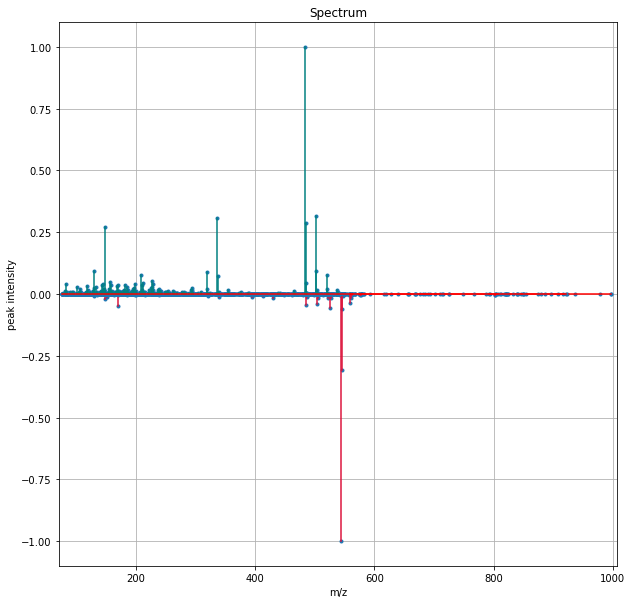

Number of peaks:  [549, 1394]


In [36]:
ID1, ID2 = 100,101
print(ID1,ID2)
print("pepmasses: ", spectra[ID1].metadata['pepmass'][0], spectra[ID2].metadata['pepmass'][0])
print("charges: ", spectra[ID1].metadata['charge'], spectra[ID2].metadata['charge'])
print("Smiles 1:", spectra[ID1].metadata['smiles'])
print("Smiles 2:", spectra[ID2].metadata['smiles'])
if 'inchi' in spectra[ID1].metadata:
    print("Inchi 1:", spectra[ID1].metadata['inchi'])
if 'inchi' in spectra[ID2].metadata:
    print("Inchi 2:", spectra[ID2].metadata['inchi'])
    
compare_spectra(spectra[ID1],spectra[ID2], min_mz = None, max_mz = None)

# Selecting data subset

## Number of unique inchikey

In [37]:
empty_entry_types = ['N/A', 'n/a', 'NA', 0, '0', '""', '', 
                     'nodata', '"InChI=n/a"', '"InChI="', 
                     'InChI=1S/N\n', '\t\r\n']  # list of types that can occur which all reflect empty entries

inchikey_lst_nonempty = [x for x in inchikey_lst if x not in empty_entry_types]
print("Unique inchikeys:", len(set(inchikey_lst_nonempty)))

Unique inchikeys: 12179


In [38]:
inchikey_lst_nonempty_first14 = [x[:14] for x in inchikey_lst if x not in empty_entry_types]
print("Unique inchikeys (first 14 characters):", len(set(inchikey_lst_nonempty_first14)))

Unique inchikeys (first 14 characters): 11017


# Make selection for data subset

As a subset we will select one spectra for every unique inchikey. We only consider the first 14 letters (which are a hash from the connectivity information of the respective InChI).  
Instead of choosing the first of each unique type, we could also pick the one with the most peaks or anything else...  
**Here we pick the spectra with the best library quality. And of those the one with the most peaks above a relative threshold (here = 0.1 of max intensity).**

In [39]:
[x.metadata['libraryquality'] for x in spectra[:10]]

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']

In [40]:
qualities = np.array([int(x.metadata['libraryquality']) for x in spectra])
np.min(qualities), np.max(qualities)

(1, 3)

### Add small function to check number of peaks above relative intensity threshold

In [41]:
def count_higher_peaks(spectrum, threshold = 0.1):
    return np.sum(np.array(spectrum.peaks)[:,1]/np.array(spectrum.peaks)[:,1].max() >= threshold)

In [50]:
count_higher_peaks(spectra[20], 0.05)

38

### Pick IDs of spectra to form the 'uniqueInchikeys' subset

In [51]:
intensity_thres = 0.05

ID_picks = []
arr_inchikey14 = np.array([x[:14] for x in inchikey_lst])

# Loop through all unique inchiques (considering 14 first characters)
for inchikey14_unique in list(set(inchikey_lst_nonempty_first14)):
    select = np.where(arr_inchikey14 == inchikey14_unique)[0]
    
    # Step 1 - select best spectrum qualities (according to gnps measure). 1 > 2 > 3
    qualities = np.array([int(spectra[x].metadata['libraryquality']) for x in select])
    select_best_quality = np.where(qualities == min(qualities))[0]
    
    # Step 2 - select the ones with most peaks > threshold
    num_peaks = np.array([count_higher_peaks(spectra[x], intensity_thres) for x in select_best_quality])
    pick = np.argmax(num_peaks)
    ID_picks.append(select[pick])

In [52]:
len(ID_picks)

11017

In [53]:
spectrumID_picks = []

for id in ID_picks:
    spectrumID_picks.append(spectra[id].metadata['spectrumid'])

In [54]:
spectrumID_picks[:10]

['CCMSLIB00000840556',
 'CCMSLIB00000579017',
 'CCMSLIB00000478582',
 'CCMSLIB00000478635',
 'CCMSLIB00004680020',
 'CCMSLIB00000845889',
 'CCMSLIB00000845164',
 'CCMSLIB00000852335',
 'CCMSLIB00000572691',
 'CCMSLIB00000847190']

In [55]:
ID_picks[:10]

[4404, 31293, 3908, 3957, 31867, 8103, 7770, 11568, 34695, 8722]

In [56]:
# Save spectrum IDs to form the subset
np.save('spectrumID_uniqueInchikey14_positive.npy', np.array(spectrumID_picks))

### Collect spectra selected for subset

In [58]:
input_file = os.path.join(PATH_MS_DATA, "cleaned_MGFs", "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra.mgf")

def pick_spectra_subset(input_mgf, picks):
    """ Collect spectra in file (line by line). And then create subset MGF.
    """
    subset_spectra = []
    with open(input_mgf) as f:
        for line in f.readlines():
            if line.startswith('BEGIN ION'):
                # Fresh spectrum
                spectrum = []
                spectrum_id = 0 #reset
            if line.startswith('SPECTRUMID'):
                spectrum_id = line.strip().split('=')[1]
            spectrum.append(line)
            
            if line.startswith('END ION'):
                if spectrum_id in picks:
                    picks.remove(spectrum_id) #shorten query list to speed up search
                    subset_spectra.append(spectrum)
    return subset_spectra

subset_spectra = pick_spectra_subset(input_file, spectrumID_picks)

### check if list of spectra looks OK

In [59]:
subset_spectra[0]

['BEGIN IONS\n',
 'PEPMASS=431.277\n',
 'CHARGE=1+\n',
 'MSLEVEL=2\n',
 'SOURCE_INSTRUMENT=ESI-Orbitrap\n',
 'FILENAME=Standards_p_1ugmL_cholic.mzXML\n',
 'SEQ=*..*\n',
 'IONMODE=positive\n',
 'ORGANISM=BILELIB19\n',
 'NAME=cholic acid M+Na\n',
 'PI=Dorrestein\n',
 'DATACOLLECTOR=A. Jarmusch\n',
 'SMILES=C[C@H](CCC(=O)O)[C@H]1CC[C@@H]2[C@@]1([C@H](C[C@H]3[C@H]2[C@@H](C[C@H]4[C@@]3(CC[C@H](C4)O)C)O)O)C\n',
 'INCHI="InChI=1S/C24H40O5/c1-13(4-7-21(28)29)16-5-6-17-22-18(12-20(27)24(16,17)3)23(2)9-8-15(25)10-14(23)11-19(22)26/h13-20,22,25-27H,4-12H2,1-3H3,(H,28,29)/t13?,14-,15+,16+,17-,18-,19+,20-,22-,23?,24?/m0/s1"\n',
 'INCHIKEY=BHQCQFFYRZLCQQ-IHELEQLESA-N\n',
 'PUBMED=N/A\n',
 'SUBMITUSER=mpanitchpakdi\n',
 'TAGS=\n',
 'LIBRARYQUALITY=1\n',
 'SPECTRUMID=CCMSLIB00005435506\n',
 'SCANS=1468\n',
 '51.387043\t1894.130249\n',
 '59.151863\t2224.843262\n',
 '60.0509\t1949.728271\n',
 '63.075016\t1864.447266\n',
 '70.296738\t1846.509399\n',
 '90.67675\t2095.799805\n',
 '91.634308\t2209.017578\n'

### Write spectra subset to MGF file

In [60]:
output_file_subset = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

with open(output_file_subset, 'w') as f:
    for c in subset_spectra[:]:
        for l in c:
            try:
                f.write(l.encode('utf8', 'replace').decode('utf8', 'replace'))
            except UnicodeEncodeError:
                f.write(l.encode('ascii', 'replace').decode('utf8', 'replace'))
                print(l)
        #f.write('\n')